# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')
    data_folder =  Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq ####### NEW HERE ###########

else:
    base_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')
    data_folder = base_folder

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [3]:
# Change the custom_function_folder to folder in your Google drive folder
# Make sure you keep the mlp_skip_two_layer.py and shared_utils.py files
from pathlib import Path
import sys

# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)

# If running locally, specify a different path
else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    custom_function_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

kaggle_api_folder = base_folder/'data/.kaggle'

# <Font color = 'indianred'>**Import Libraries**

In [4]:
import torch
from torchvision import transforms
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.tuner import Tuner
from torch.optim.lr_scheduler import OneCycleLR

from multiclass_lightning_module_v0 import MultiClassLightningModule
from data_module_dog_breed import DogBreedDataModule

from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

import wandb ########### NEW HERE ###########

# <Font color = 'indianred'>**Setup Trainer**

## <Font color = 'indianred'>**Transformations**

In [5]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            # Resize the shorter side of the image to (500, 375) pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [
            # Resize the shorter side of the image to 640 pixels
            transforms.Resize((500, 375)),
            # Convert image to PyTorch tensor
            transforms.ToTensor(),
            # Normalize tensor values to range [-1, 1]
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

# <Font color = 'indianred'>**Setup Model, DataModule, Lightning Module**

In [7]:
# Define the model architecture and training parameters

# model hyperparameters
num_features = 3 * 500 * 375
hidden_dim1 = 500
hidden_dim2 = 500
num_classes = 120

# datamodule hyperprameters
batch_size = 1024
train_transform=data_transforms["train"]
test_transform=data_transforms["test"]
batch_size=64
seed=42
fraction_train=0.8
small_subset = True
num_samples_small = 1024

# lightning module hyperparameters
epochs=2
optimizer_cls= torch.optim.AdamW
loss_fn=torch.nn.CrossEntropyLoss()
metric_cls=torchmetrics.Accuracy
num_classes=120
learning_rate  = 0.0001
log_every_n_steps=1
log_test_metrics=True
display_metrics=True
optimizer_params={'weight_decay': 10}
scheduler_cls=OneCycleLR
scheduler_options = {'interval': 'step', 'frequency': 1}
scheduler_params = {'max_lr': 0.0005, 'total_steps':epochs * 1024//batch_size}


# Set a random seed for reproducibility
torch.manual_seed(seed)

# Specify Model
model = TwoLayerMLPBN(num_features, hidden_dim1, hidden_dim2, num_classes)

# Specify DataModule
dm = DogBreedDataModule(data_dir=data_folder,
                        kaggle_api_folder=kaggle_api_folder,
                        train_transform=train_transform,
                        test_transform=test_transform,
                        batch_size=batch_size,
                        seed=seed,
                        fraction_train=fraction_train,
                        small_subset = True ,
                        num_samples_small = 1024)

# Specify LightningModule
lightning_model = MultiClassLightningModule(model=model,
                                            optimizer_cls= torch.optim.AdamW,
                                            loss_fn=torch.nn.CrossEntropyLoss(),
                                            metric_cls=torchmetrics.Accuracy,
                                            num_classes=num_classes,
                                            learning_rate  = learning_rate,
                                            log_every_n_steps=log_every_n_steps,
                                            log_test_metrics=True,
                                            display_metrics=True,
                                            optimizer_params=optimizer_params,
                                            scheduler_cls=OneCycleLR,
                                            scheduler_params=scheduler_params,
                                            scheduler_options=scheduler_options,
                                            )



## <Font color = 'indianred'>**Setup Callbacks, Logger, Trainer**

In [8]:
lr_monitor = LearningRateMonitor(logging_interval='step')
log_dir = model_folder/'logs'
model_checkpoint_callback = ModelCheckpoint(dirpath=log_dir,
                                            save_top_k=1, mode="max", monitor="val_metric", save_last=True)
callbacks = [model_checkpoint_callback, lr_monitor ]

######### NEW #################################
wandb_logger = WandbLogger(project="Imagenette", name = 'wandbcheck1', save_dir=log_dir)
wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': epochs})
wandb_logger.watch(model)

csv_logger = CSVLogger(save_dir=log_dir, name="two_layer")
csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': epochs})

##################################################


trainer = pl.Trainer(
        callbacks=callbacks,
        max_epochs=epochs,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices= 'auto',  # Uses all available GPUs if applicable
        deterministic=True,
        log_every_n_steps = log_every_n_steps,
        logger= [csv_logger, wandb_logger], ######## NEW HERE ##############


    )

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# <Font color = 'indianred'>**Learning Rate Finder**

In [9]:
# tuner = Tuner(trainer)
# lr_finder = tuner.lr_find(lightning_model, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
# fig = lr_finder.plot(suggest=True)

In [10]:
# get suggestion
# new_lr = lr_finder.suggestion()
# print(new_lr)

# <Font color = 'indianred'>**Training and Evaluations**

In [11]:
trainer.fit(lightning_model, dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total params
1,126.252 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.78, Val_Metric: 0.02 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.77, Val_Metric: 0.02 | Train_Loss: 4.83, Train_Metric: 0.02


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 4.73, Val_Metric: 0.02 | Train_Loss: 4.20, Train_Metric: 0.21


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# <Font color = 'indianred'>**Plot Losses**

In [12]:
trainer.logger

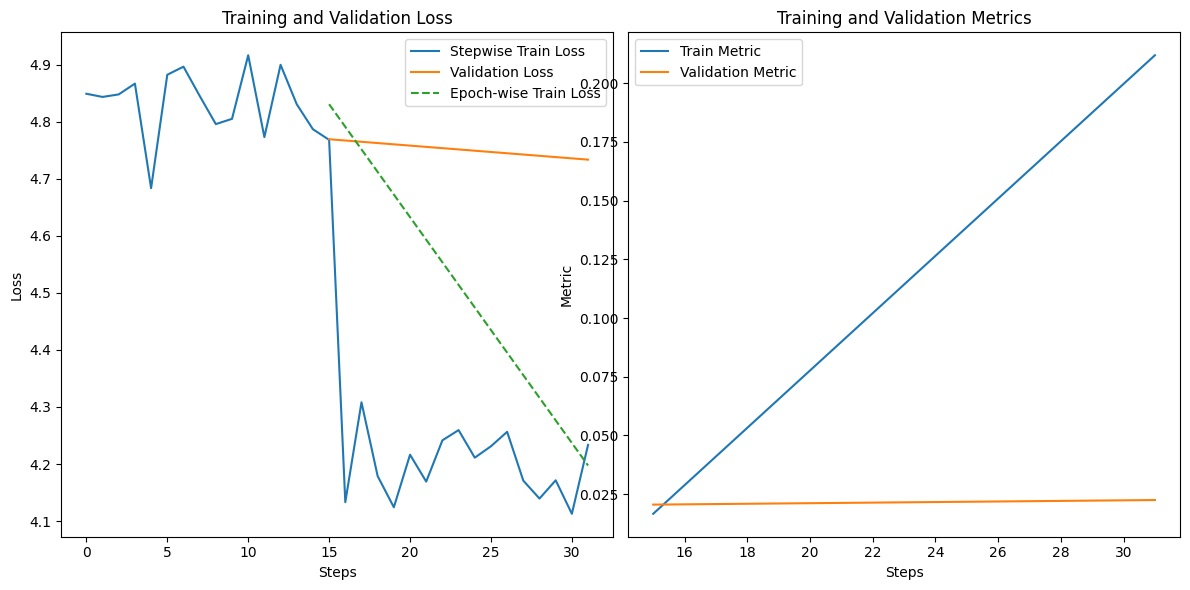

In [13]:
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)


# <Font color = 'indianred'>**Evaluation**

In [14]:
ckpt_path = trainer.checkpoint_callback.best_model_path
ckpt_path

'/content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/logs/epoch=1-step=32-v1.ckpt'

In [15]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
# test_acc = trainer.test(dataloaders=dm.test_dataloader(), ckpt_path=ckpt_path, verbose=False)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/logs/epoch=1-step=32-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/logs/epoch=1-step=32-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 4.14, Val_Metric: 0.28 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/logs/epoch=1-step=32-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/logs/epoch=1-step=32-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 4.73, Val_Metric: 0.02 | 

In [16]:
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
# print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Train Accuracy: 27.73
Validation Accuracy: 2.25


In [17]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██
lr-AdamW,▁▂▂▃▄▅▇▇█████▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁
train_loss_epoch,█▁
train_loss_step,▇▇▇█▆██▇▇▇█▇█▇▇▇▁▃▂▁▂▁▂▂▂▂▂▂▁▂▁▂
train_metric,▁█
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,██▁█
val_metric,▁▁█▁
epoch,2
lr-AdamW,0.0
train_loss_epoch,4.19733
